**Part-of-Speech Tagging Using HMMs**

---





### **Libraries, Data Upload (JSON File)**

In [ ]:
import json
import random
import math
import collections
from collections import defaultdict

# For tokenization using NLTK:
import nltk
nltk.download('punkt')

from google.colab import files

uploaded = files.upload()
json_filename = 'penn-data.json'
with open(json_filename, 'r') as f:
    raw_data = json.load(f)

print("Total raw data entries:", len(raw_data))
print("Sample raw entry:", raw_data[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Saving penn-data.json to penn-data (3).json
Total raw data entries: 3914
Sample raw entry: ['Pierre Vinken, 61 years old, will join the board as a nonexecutive director Nov. 29.', ['NNP', 'NNP', 'CD', 'NNS', 'JJ', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD']]


### **Data Cleaning & Tokenization**

In [ ]:
def clean_and_tokenize(data):
    clean = []
    skipped = 0
    for sentence, tags in data:
        if isinstance(sentence, str):
            tokens_ws = sentence.split()
            if len(tokens_ws) == len(tags):
                tokens = tokens_ws
            else:
                tokens_nltk = nltk.word_tokenize(sentence)
                if len(tokens_nltk) == len(tags):
                    tokens = tokens_nltk
                else:
                    print("Skipping sentence due to token/tag length mismatch:")
                    print("Using whitespace split:", tokens_ws)
                    print("Using nltk.tokenize:", tokens_nltk)
                    print("Tags:", tags)
                    skipped += 1
                    continue
        else:
            tokens = sentence

        clean.append((tokens, tags))
    print(f"Cleaned data: kept {len(clean)} out of {len(data)} entries. Skipped {skipped} entries.")
    return clean

data = clean_and_tokenize(raw_data)

#splitting the data as per question given in assignment into training and testing (80:20 split)
def split_data(data, train_ratio=0.8, seed=42):
    random.seed(seed)
    random.shuffle(data)
    split_point = int(len(data) * train_ratio)
    return data[:split_point], data[split_point:]

train_data, test_data = split_data(data, train_ratio=0.8)
print("Training sentences:", len(train_data))
print("Test sentences:", len(test_data))


Cleaned data: kept 3914 out of 3914 entries. Skipped 0 entries.
Training sentences: 3131
Test sentences: 783


### **Tag Collapsing Functions**

In [ ]:
#def tryfunc(tag):
def collapse_tag(tag):
    noun_tags = {"NN", "NNS", "NNP", "NNPS"}
    verb_tags = {"VB", "VBD", "VBG", "VBN", "VBP", "VBZ"}
    adj_adv_tags = {"JJ", "JJR", "JJS", "RB", "RBR", "RBS"}
    if tag in noun_tags:
        return "N"
    elif tag in verb_tags:
        return "V"
    elif tag in adj_adv_tags:
        return "A"
    else:
        return "O"

def collapse_data(data):
    new_data = []
    for sentence, tags in data:
        new_tags = [collapse_tag(tag) for tag in tags]
        new_data.append((sentence, new_tags))
    return new_data

sample_sentence, sample_tags = train_data[0]
print("Sample original tags:", sample_tags)
print("Sample collapsed tags:", [collapse_tag(tag) for tag in sample_tags])


Sample original tags: ['DT', 'NN', 'VBD', 'IN', 'PRP', 'VBZ', 'VBN', 'NN', 'IN', 'CD', 'CD', 'IN', 'DT', 'NN', 'IN', 'CD', 'CC', 'VBD', 'RP', 'IN', 'CD', 'CD', 'NNS', 'IN', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', 'CD']
Sample collapsed tags: ['O', 'N', 'V', 'O', 'O', 'V', 'V', 'N', 'O', 'O', 'O', 'O', 'O', 'N', 'O', 'O', 'O', 'V', 'O', 'O', 'O', 'O', 'N', 'O', 'A', 'N', 'O', 'O', 'A', 'N', 'O', 'O']


### **First Order HMM (Using P(w|t))**

In [ ]:
# First Order HMM implementation

class HMMFirstOrder:
    def __init__(self):
        self.initial_probs = {}
        self.transition_probs = {}
        self.emission_probs = {}
        self.tags = set()
        self.vocab = set()
        self.default_tag = None

    def train(self, data):
        initial_counts = collections.Counter()
        transition_counts = defaultdict(collections.Counter)
        emission_counts = defaultdict(collections.Counter)
        tag_counts = collections.Counter()

        for sentence, tags in data:
            if not sentence:
                continue
            initial_counts[tags[0]] += 1
            tag_counts[tags[0]] += 1
            prev_tag = None
            for word, tag in zip(sentence, tags):
                self.vocab.add(word)
                emission_counts[tag][word] += 1
                tag_counts[tag] += 1
                if prev_tag is not None:
                    transition_counts[prev_tag][tag] += 1
                prev_tag = tag
            self.tags.update(tags)

        total_sentences = sum(initial_counts.values())
        self.initial_probs = {tag: (initial_counts[tag] / total_sentences) for tag in initial_counts}

        self.transition_probs = {}
        for prev_tag in transition_counts:
            total = sum(transition_counts[prev_tag].values())
            self.transition_probs[prev_tag] = {tag: (transition_counts[prev_tag][tag] / total)
                                               for tag in transition_counts[prev_tag]}

        self.emission_probs = {}
        for tag in emission_counts:
            total = sum(emission_counts[tag].values())
            self.emission_probs[tag] = {word: (emission_counts[tag][word] / total)
                                        for word in emission_counts[tag]}

        if tag_counts:
            self.default_tag = tag_counts.most_common(1)[0][0]
        else:
            self.default_tag = None

    def viterbi(self, sentence):
        # Viterbi algorithm in log-space.
        V = [{}]
        path = {}
        for tag in self.tags:
            if sentence[0] not in self.vocab:
                emission = 1.0 if tag == self.default_tag else 1e-6
            else:
                emission = self.emission_probs.get(tag, {}).get(sentence[0], 1e-6)
            V[0][tag] = math.log(self.initial_probs.get(tag, 1e-6)) + math.log(emission)
            path[tag] = [tag]

        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}
            for curr_tag in self.tags:
                best_prob = float('-inf')
                best_prev = None
                if sentence[t] not in self.vocab:
                    emission = 1.0 if curr_tag == self.default_tag else 1e-6
                else:
                    emission = self.emission_probs.get(curr_tag, {}).get(sentence[t], 1e-6)
                for prev_tag in self.tags:
                    trans = self.transition_probs.get(prev_tag, {}).get(curr_tag, 1e-6)
                    prob = V[t-1][prev_tag] + math.log(trans) + math.log(emission)
                    if prob > best_prob:
                        best_prob = prob
                        best_prev = prev_tag
                V[t][curr_tag] = best_prob
                new_path[curr_tag] = path[best_prev] + [curr_tag]
            path = new_path

        final_tag = max(V[len(sentence)-1].items(), key=lambda x: x[1])[0]
        return path[final_tag]


### **Second Order HMM (Using P(tᵢ|tᵢ₋₂, tᵢ₋₁))**

In [ ]:
class HMMSecondOrder:
    def __init__(self):
        self.initial_probs = {}
        self.second_probs = {}
        self.transition_probs = {}
        self.emission_probs = {}
        self.tags = set()
        self.vocab = set()
        self.default_tag = None

    def train(self, data):
        initial_counts = collections.Counter()
        second_counts = defaultdict(collections.Counter)
        transition_counts = defaultdict(lambda: defaultdict(collections.Counter))
        emission_counts = defaultdict(collections.Counter)
        tag_counts = collections.Counter()

        for sentence, tags in data:
            if not sentence:
                continue
            initial_counts[tags[0]] += 1
            tag_counts[tags[0]] += 1

            if len(sentence) > 1:
                second_counts[tags[0]][tags[1]] += 1
                tag_counts[tags[1]] += 1

            for i, (word, tag) in enumerate(zip(sentence, tags)):
                self.vocab.add(word)
                emission_counts[tag][word] += 1
                if i >= 2:
                    transition_counts[tags[i-2]][tags[i-1]][tag] += 1
                    tag_counts[tag] += 1
            self.tags.update(tags)

        total_sentences = sum(initial_counts.values())
        self.initial_probs = {tag: (initial_counts[tag] / total_sentences) for tag in initial_counts}

        self.second_probs = {}
        for tag1 in second_counts:
            total = sum(second_counts[tag1].values())
            self.second_probs[tag1] = {tag2: (second_counts[tag1][tag2] / total)
                                       for tag2 in second_counts[tag1]}

        self.transition_probs = {}
        for tag_i_2 in transition_counts:
            self.transition_probs[tag_i_2] = {}
            for tag_i_1 in transition_counts[tag_i_2]:
                total = sum(transition_counts[tag_i_2][tag_i_1].values())
                self.transition_probs[tag_i_2][tag_i_1] = {tag: (transition_counts[tag_i_2][tag_i_1][tag] / total)
                                                          for tag in transition_counts[tag_i_2][tag_i_1]}

        self.emission_probs = {}
        for tag in emission_counts:
            total = sum(emission_counts[tag].values())
            self.emission_probs[tag] = {word: (emission_counts[tag][word] / total)
                                        for word in emission_counts[tag]}

        if tag_counts:
            self.default_tag = tag_counts.most_common(1)[0][0]
        else:
            self.default_tag = None

    def viterbi(self, sentence):
        n = len(sentence)
        if n == 0:
            return []
        V = {}
        path = {}

        V[0] = {}
        for tag in self.tags:
            if sentence[0] not in self.vocab:
                emission = 1.0 if tag == self.default_tag else 1e-6
            else:
                emission = self.emission_probs.get(tag, {}).get(sentence[0], 1e-6)
            V[0][(None, tag)] = math.log(self.initial_probs.get(tag, 1e-6)) + math.log(emission)
            path[(None, tag)] = [tag]

        if n < 2:
            best_state = max(V[0].items(), key=lambda x: x[1])[0]
            return path[best_state]

        V[1] = {}
        new_path = {}
        for (dummy, tag1), prob in V[0].items():
            for tag2 in self.tags:
                trans = self.second_probs.get(tag1, {}).get(tag2, 1e-6)
                if sentence[1] not in self.vocab:
                    emission = 1.0 if tag2 == self.default_tag else 1e-6
                else:
                    emission = self.emission_probs.get(tag2, {}).get(sentence[1], 1e-6)
                score = prob + math.log(trans) + math.log(emission)
                key = (tag1, tag2)
                if key not in V[1] or score > V[1][key]:
                    V[1][key] = score
                    new_path[key] = path[(dummy, tag1)] + [tag2]
        path = new_path

        for t in range(2, n):
            V[t] = {}
            new_path = {}
            for (tag_i_2, tag_i_1), prob in V[t-1].items():
                for tag in self.tags:
                    trans = self.transition_probs.get(tag_i_2, {}).get(tag_i_1, {}).get(tag, 1e-6)
                    if sentence[t] not in self.vocab:
                        emission = 1.0 if tag == self.default_tag else 1e-6
                    else:
                        emission = self.emission_probs.get(tag, {}).get(sentence[t], 1e-6)
                    score = prob + math.log(trans) + math.log(emission)
                    key = (tag_i_1, tag)
                    if key not in V[t] or score > V[t][key]:
                        V[t][key] = score
                        new_path[key] = path[(tag_i_2, tag_i_1)] + [tag]
            path = new_path

        best_state = max(V[n-1].items(), key=lambda x: x[1])[0]
        return path[best_state]


### **First Order HMM with Previous Word Dependency (P(wᵢ|tᵢ, wᵢ₋₁))**

In [ ]:
class HMMFirstOrderPrevWord:
    def __init__(self):
        self.initial_probs = {}
        self.transition_probs = {}
        self.emission_probs = {}
        self.tags = set()
        self.vocab = set()
        self.default_tag = None
        self.START = "<s>"

    def train(self, data):
        initial_counts = collections.Counter()
        transition_counts = defaultdict(collections.Counter)
        emission_counts = defaultdict(lambda: defaultdict(collections.Counter))
        tag_counts = collections.Counter()

        for sentence, tags in data:
            if len(sentence) != len(tags):
                print("Skipping sentence due to length mismatch:")
                print("Sentence:", sentence)
                print("Tags:", tags)
                continue
            if not sentence:
                continue


            initial_counts[tags[0]] += 1
            tag_counts[tags[0]] += 1
            prev_word = self.START

            for i, (word, tag) in enumerate(zip(sentence, tags)):
                self.vocab.add(word)
                emission_counts[tag][prev_word][word] += 1
                if i > 0:
                    transition_counts[tags[i-1]][tag] += 1
                tag_counts[tag] += 1
                prev_word = word
            self.tags.update(tags)

        total_sentences = sum(initial_counts.values())
        self.initial_probs = {tag: (initial_counts[tag] / total_sentences)
                              for tag in initial_counts}

        self.transition_probs = {}
        for prev_tag in transition_counts:
            total = sum(transition_counts[prev_tag].values())
            self.transition_probs[prev_tag] = {tag: (transition_counts[prev_tag][tag] / total)
                                               for tag in transition_counts[prev_tag]}

        self.emission_probs = {}
        for tag in emission_counts:
            self.emission_probs[tag] = {}
            for prev_word in emission_counts[tag]:
                total = sum(emission_counts[tag][prev_word].values())
                self.emission_probs[tag][prev_word] = {word: (emission_counts[tag][prev_word][word] / total)
                                                       for word in emission_counts[tag][prev_word]}

        if tag_counts:
            self.default_tag = tag_counts.most_common(1)[0][0]
        else:
            self.default_tag = None

    def viterbi(self, sentence):
        n = len(sentence)
        if n == 0:
            return []
        V = [{}]
        path = {}

        for tag in self.tags:
            if sentence[0] not in self.vocab:
                emission = 1.0 if tag == self.default_tag else 1e-6
            else:
                emission = self.emission_probs.get(tag, {}).get(self.START, {}).get(sentence[0], 1e-6)
            V[0][tag] = math.log(self.initial_probs.get(tag, 1e-6)) + math.log(emission)
            path[tag] = [tag]

        for t in range(1, n):
            V.append({})
            new_path = {}
            for curr_tag in self.tags:
                best_prob = float('-inf')
                best_prev = None
                if sentence[t] not in self.vocab:
                    emission = 1.0 if curr_tag == self.default_tag else 1e-6
                else:
                    emission = self.emission_probs.get(curr_tag, {}).get(sentence[t-1], {}).get(sentence[t], 1e-6)
                for prev_tag in self.tags:
                    trans = self.transition_probs.get(prev_tag, {}).get(curr_tag, 1e-6)
                    prob = V[t-1][prev_tag] + math.log(trans) + math.log(emission)
                    if prob > best_prob:
                        best_prob = prob
                        best_prev = prev_tag
                V[t][curr_tag] = best_prob
                new_path[curr_tag] = path[best_prev] + [curr_tag]
            path = new_path


        final_tag = max(V[n-1].items(), key=lambda x: x[1])[0]
        return path[final_tag]


### **Evaluation Function**

In [ ]:
def evaluate(model, test_data):
    total_tokens = 0
    correct_tokens = 0
    tag_correct = collections.Counter()
    tag_total = collections.Counter()

    for sentence, true_tags in test_data:
        if not sentence:
            continue
        predicted_tags = model.viterbi(sentence)
        for pred, true in zip(predicted_tags, true_tags):
            total_tokens += 1
            tag_total[true] += 1
            if pred == true:
                correct_tokens += 1
                tag_correct[true] += 1
    overall_accuracy = correct_tokens / total_tokens if total_tokens else 0
    tag_wise_accuracy = {tag: (tag_correct[tag] / tag_total[tag] if tag_total[tag] else 0)
                         for tag in tag_total}
    return overall_accuracy, tag_wise_accuracy


### **Training, Testing, and Analysis**

In [ ]:

print("=== Running on the 36-tag (original) dataset ===")
print("Training sentences:", len(train_data), "Test sentences:", len(test_data))


model_fo = HMMFirstOrder()
model_fo.train(train_data)
acc, tag_acc = evaluate(model_fo, test_data)
print("\n[First Order HMM (36-tag)]")
print("Overall Accuracy: {:.2f}%".format(acc * 100))
print("Tag-wise Accuracy:", tag_acc)


model_so = HMMSecondOrder()
model_so.train(train_data)
acc, tag_acc = evaluate(model_so, test_data)
print("\n[Second Order HMM (36-tag)]")
print("Overall Accuracy: {:.2f}%".format(acc * 100))
print("Tag-wise Accuracy:", tag_acc)

model_fo_pw = HMMFirstOrderPrevWord()
model_fo_pw.train(train_data)
acc, tag_acc = evaluate(model_fo_pw, test_data)
print("\n[First Order HMM with Previous Word Dependency (36-tag)]")
print("Overall Accuracy: {:.2f}%".format(acc * 100))
print("Tag-wise Accuracy:", tag_acc)


print("\n=== Running on the Collapsed 4-tag dataset ===")
train_data_collapsed = collapse_data(train_data)
test_data_collapsed = collapse_data(test_data)


model_fo_collapsed = HMMFirstOrder()
model_fo_collapsed.train(train_data_collapsed)
acc, tag_acc = evaluate(model_fo_collapsed, test_data_collapsed)
print("\n[First Order HMM (Collapsed)]")
print("Overall Accuracy: {:.2f}%".format(acc * 100))
print("Tag-wise Accuracy:", tag_acc)


model_so_collapsed = HMMSecondOrder()
model_so_collapsed.train(train_data_collapsed)
acc, tag_acc = evaluate(model_so_collapsed, test_data_collapsed)
print("\n[Second Order HMM (Collapsed)]")
print("Overall Accuracy: {:.2f}%".format(acc * 100))
print("Tag-wise Accuracy:", tag_acc)


model_fo_pw_collapsed = HMMFirstOrderPrevWord()
model_fo_pw_collapsed.train(train_data_collapsed)
acc, tag_acc = evaluate(model_fo_pw_collapsed, test_data_collapsed)
print("\n[First Order HMM with Previous Word Dependency (Collapsed)]")
print("Overall Accuracy: {:.2f}%".format(acc * 100))
print("Tag-wise Accuracy:", tag_acc)


=== Running on the 36-tag (original) dataset ===
Training sentences: 3131 Test sentences: 783

[First Order HMM (36-tag)]
Overall Accuracy: 85.60%
Tag-wise Accuracy: {'NNS': 0.7365319865319865, 'VBD': 0.8476190476190476, 'VBN': 0.6674259681093394, 'IN': 0.9741334712881531, 'DT': 0.9924194567277321, 'PRP': 0.9756838905775076, 'EX': 0.9411764705882353, 'MD': 0.9141104294478528, 'VB': 0.7926078028747433, 'NN': 0.9753036437246964, 'TO': 1.0, 'PRP$': 0.99375, 'CC': 0.9976958525345622, 'VBG': 0.6387959866220736, 'JJ': 0.7231985940246046, 'NNP': 0.7357485348961108, 'VBZ': 0.8447368421052631, 'WRB': 0.9767441860465116, 'RB': 0.7592954990215264, 'CD': 0.6537867078825348, 'VBP': 0.752, 'WP': 0.9767441860465116, 'NNPS': 0.4230769230769231, 'WDT': 0.8924731182795699, 'JJS': 0.9428571428571428, 'JJR': 0.891566265060241, ':': 1.0, 'RP': 0.6304347826086957, 'UH': 0.0, 'RBR': 0.32142857142857145, '-LRB-': 1.0, '-RRB-': 1.0, 'LS': 0.0, "''": 1.0, 'RBS': 1.0, 'PDT': 0.5, 'WP$': 1.0, '#': 0.6666666666666

### **PLOTS**

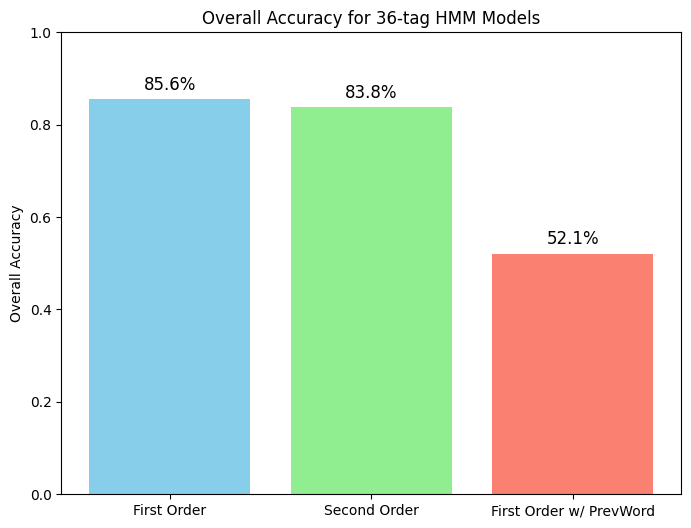

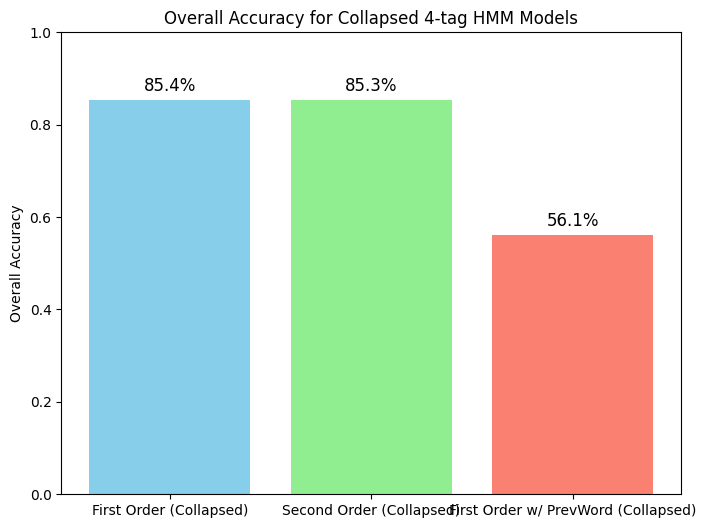

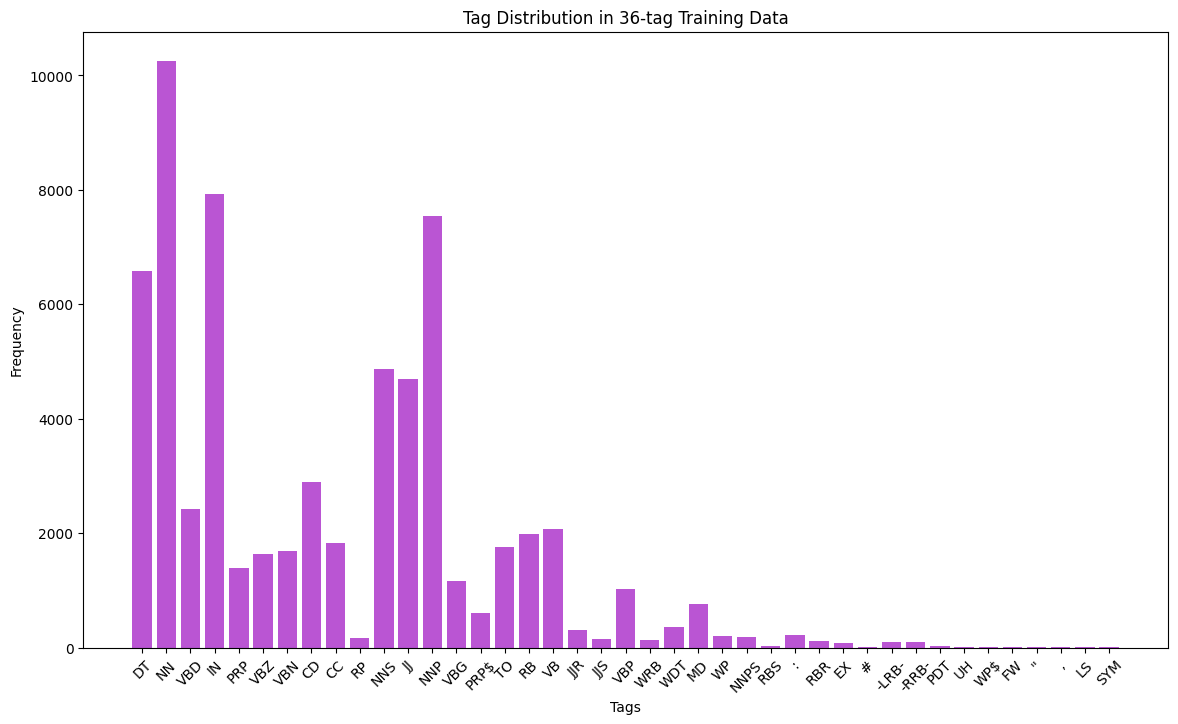

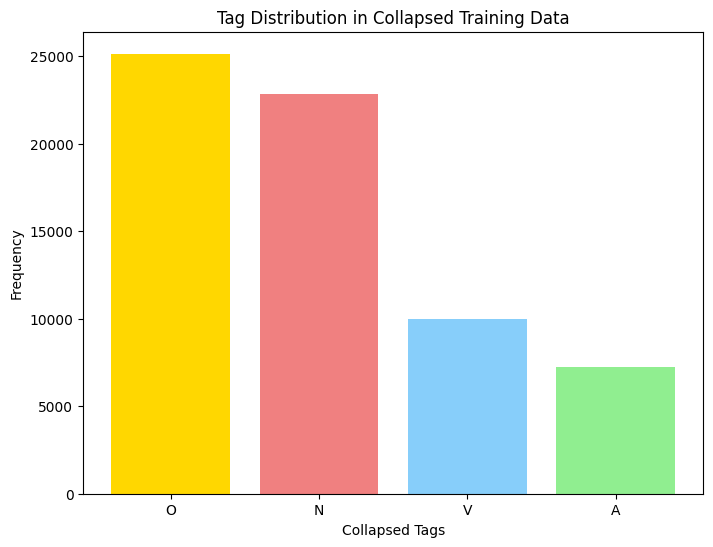

In [ ]:
import matplotlib.pyplot as plt


models_36 = ["First Order", "Second Order", "First Order w/ PrevWord"]
overall_acc_36 = [0.8560, 0.8377, 0.5211]  # 85.60%, 83.77%, 52.11%

models_collapsed = ["First Order (Collapsed)", "Second Order (Collapsed)", "First Order w/ PrevWord (Collapsed)"]
overall_acc_collapsed = [0.8535, 0.8534, 0.5608]  # 85.35%, 85.34%, 56.08%


plt.figure(figsize=(8, 6))
plt.bar(models_36, overall_acc_36, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.ylabel("Overall Accuracy")
plt.title("Overall Accuracy for 36-tag HMM Models")
for i, acc in enumerate(overall_acc_36):
    plt.text(i, acc + 0.02, f"{acc*100:.1f}%", ha='center', fontsize=12)
plt.show()


plt.figure(figsize=(8, 6))
plt.bar(models_collapsed, overall_acc_collapsed, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.ylabel("Overall Accuracy")
plt.title("Overall Accuracy for Collapsed 4-tag HMM Models")
for i, acc in enumerate(overall_acc_collapsed):
    plt.text(i, acc + 0.02, f"{acc*100:.1f}%", ha='center', fontsize=12)
plt.show()

def get_tag_distribution(data):
    from collections import Counter
    dist = Counter()
    for sentence, tags in data:
        dist.update(tags)
    return dist


dist_36 = get_tag_distribution(train_data)
dist_collapsed = get_tag_distribution(train_data_collapsed)


tags_36 = list(dist_36.keys())
counts_36 = list(dist_36.values())

plt.figure(figsize=(14, 8))
plt.bar(tags_36, counts_36, color='mediumorchid')
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.title("Tag Distribution in 36-tag Training Data")
plt.xticks(rotation=45)
plt.show()

tags_collapsed = list(dist_collapsed.keys())
counts_collapsed = list(dist_collapsed.values())

plt.figure(figsize=(8, 6))
plt.bar(tags_collapsed, counts_collapsed, color=['gold', 'lightcoral', 'lightskyblue', 'lightgreen'])
plt.xlabel("Collapsed Tags")
plt.ylabel("Frequency")
plt.title("Tag Distribution in Collapsed Training Data")
plt.show()
